In [82]:
import collections
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.model import (
    rnn_classification_model,
    compile_classification_model,
)
from rna_learn.transform import (
    sequence_embedding, 
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
    normalize, 
    denormalize,
)
from rna_learn.load import load_rna_nucleotides_dataset
from rna_learn.vae import variational_autoencoder, compile_vae

In [2]:
seed = 123
np.random.seed(seed)

sns.set(palette='colorblind', font_scale=1.3)

## Model

In [3]:
rna = 'trna'
alphabet = ['A', 'T', 'G', 'C']
alphabet_size = len(alphabet)
metadata_folder = f'data/rna_temp/tab/{rna}.tab'
sequences_folder = 'data/rna_temp/seq/'
classes = ['psychrophile', 'mesophile', 'thermophile', 'hyperthermophile']
n_classes = len(classes)
n_entries_per_class = 153

In [4]:
output_path = os.path.join(os.getcwd(), 'saved_models', f'seed_{seed}', f'{rna}_classification.h5')

model = rnn_classification_model(alphabet_size=alphabet_size, n_classes=n_classes, n_lstm=2)
compile_classification_model(model, learning_rate=1e-4)

model.load_weights(output_path)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, None, 4)]         0         
_________________________________________________________________
masking (Masking)            (None, None, 4)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         42000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404   

## Data

In [5]:
%%time
metadata = pd.read_csv(metadata_folder, delimiter='\t')
metadata['category'] = metadata['temp.cat']

sequences = load_rna_nucleotides_dataset(metadata, sequences_folder)

CPU times: user 178 ms, sys: 138 ms, total: 315 ms
Wall time: 316 ms


In [6]:
y_balanced, balanced_metadata = make_dataset_balanced(metadata, n_entries_per_class=n_entries_per_class)

In [7]:
balanced_sequences = load_rna_nucleotides_dataset(balanced_metadata, sequences_folder)
y = one_hot_encode_classes(y_balanced, classes)
x = sequence_embedding(balanced_sequences, alphabet)
x_train, y_train, x_test, y_test, train_idx, test_idx = split_train_test_set(
    x, y, test_ratio=0.2, return_indices=True)

## Evaluation

In [8]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Loss: 1.2486
Accuracy: 0.4098


## Confusion matrix (test set)

In [9]:
y_pred = model(x_test)

labels = [np.argmax(el) for el in y_test]
predictions = [np.argmax(el) for el in y_pred]
conf = tf.math.confusion_matrix(labels, predictions).numpy()
conf

array([[17,  5,  2,  2],
       [15,  5,  7,  4],
       [13,  4,  9, 10],
       [ 3,  4,  3, 19]], dtype=int32)

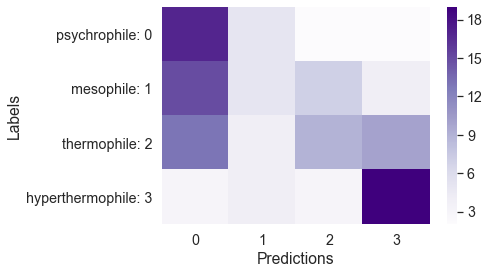

In [10]:
df_cm = pd.DataFrame(
    conf, 
    index=[f'{c}: {i}' for i, c in enumerate(classes)],
    columns=[f'{i}' for i, c in enumerate(classes)],
)
ax = sns.heatmap(df_cm, cmap="Purples");
ax.set_xlabel('Predictions');
ax.set_ylabel('Labels');

In [11]:
conf_sum = np.sum(conf, axis=1)
for i in range(len(classes)):
    acc = 100 * conf[i, i] / conf_sum[i]
    print(f'Accuracy for class {classes[i]}: {acc:.1f}%')

Accuracy for class psychrophile: 65.4%
Accuracy for class mesophile: 16.1%
Accuracy for class thermophile: 25.0%
Accuracy for class hyperthermophile: 65.5%


## Confusion matrix (train set)

In [12]:
y_pred_t = model(x_train)

labels_t = [np.argmax(el) for el in y_train]
predictions_t = [np.argmax(el) for el in y_pred_t]
conf_t = tf.math.confusion_matrix(labels_t, predictions_t).numpy()
conf_t

array([[91, 14, 15,  7],
       [61, 26, 22, 13],
       [41, 17, 31, 28],
       [16,  4, 19, 85]], dtype=int32)

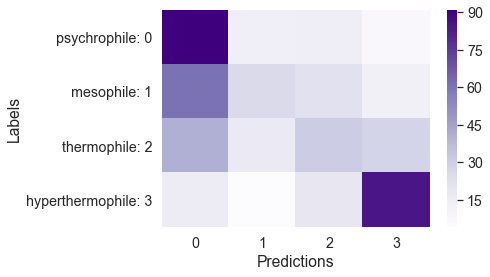

In [13]:
df_cm_t = pd.DataFrame(
    conf_t, 
    index=[f'{c}: {i}' for i, c in enumerate(classes)],
    columns=[f'{i}' for i, c in enumerate(classes)],
)
ax = sns.heatmap(df_cm_t, cmap="Purples");
ax.set_xlabel('Predictions');
ax.set_ylabel('Labels');

In [14]:
conf_sum_t = np.sum(conf_t, axis=1)
for i in range(len(classes)):
    acc = 100 * conf_t[i, i] / conf_sum_t[i]
    print(f'Accuracy for class {classes[i]}: {acc:.1f}%')

Accuracy for class psychrophile: 71.7%
Accuracy for class mesophile: 21.3%
Accuracy for class thermophile: 26.5%
Accuracy for class hyperthermophile: 68.5%


## VAE

In [15]:
prior, encoder, decoder, vae = variational_autoencoder(n_inputs=100, encoding_size=2, n_hidden=300)
compile_vae(vae, learning_rate=1e-4)
vae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               30300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1505      
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 2), (None, 2))    0         
_________________________________________________________________
model_2 (Model)              (None, 100)               61100     
Total params: 92,905
Trainable params: 92,905
Non-trainable params: 0
_______________________________________________________

In [16]:
layer_name = 'dense'
intermediate_layer_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output,
)
train_logits = intermediate_layer_model(x_train).numpy()
test_logits = intermediate_layer_model(x_test).numpy()
print(train_logits.shape, test_logits.shape)

(490, 100) (122, 100)


In [17]:
do_train_vae = False
vae_model_path = os.path.join(os.getcwd(), 'saved_models', f'seed_{seed}', f'{rna}_vae.h5')

if do_train_vae:
    vae.fit(
        train_logits, train_logits,
        validation_data=(test_logits, test_logits),
        batch_size=32,
        epochs=200,
    )
    vae.save(vae_model_path)
else:
    vae.load_weights(vae_model_path)

Train on 490 samples, validate on 122 samples
Epoch 1/200
490/490 [==============================] - 2s 3ms/sample - loss: 58.2549 - val_loss: 56.7157
Epoch 2/200
490/490 [==============================] - 0s 123us/sample - loss: 56.8497 - val_loss: 55.1827
Epoch 3/200
490/490 [==============================] - 0s 112us/sample - loss: 55.2468 - val_loss: 53.7047
Epoch 4/200
490/490 [==============================] - 0s 103us/sample - loss: 53.2585 - val_loss: 51.1662
Epoch 5/200
490/490 [==============================] - 0s 106us/sample - loss: 51.3165 - val_loss: 48.8007
Epoch 6/200
490/490 [==============================] - 0s 108us/sample - loss: 49.2814 - val_loss: 46.1809
Epoch 7/200
490/490 [==============================] - 0s 329us/sample - loss: 46.2690 - val_loss: 42.9845
Epoch 8/200
490/490 [==============================] - 0s 116us/sample - loss: 43.6229 - val_loss: 38.1457
Epoch 9/200
490/490 [==============================] - 0s 104us/sample - loss: 40.7398 - val_loss: 3

Epoch 76/200
490/490 [==============================] - 0s 106us/sample - loss: -76.2455 - val_loss: -104.1112
Epoch 77/200
490/490 [==============================] - 0s 102us/sample - loss: -77.1413 - val_loss: -107.1581
Epoch 78/200
490/490 [==============================] - 0s 100us/sample - loss: -76.5459 - val_loss: -108.2682
Epoch 79/200
490/490 [==============================] - 0s 101us/sample - loss: -79.1573 - val_loss: -107.8220
Epoch 80/200
490/490 [==============================] - 0s 100us/sample - loss: -80.5106 - val_loss: -108.9979
Epoch 81/200
490/490 [==============================] - 0s 105us/sample - loss: -80.6278 - val_loss: -110.4571
Epoch 82/200
490/490 [==============================] - 0s 103us/sample - loss: -81.2680 - val_loss: -110.5782
Epoch 83/200
490/490 [==============================] - 0s 109us/sample - loss: -82.2121 - val_loss: -112.1137
Epoch 84/200
490/490 [==============================] - 0s 104us/sample - loss: -83.1320 - val_loss: -112.0116
E

Epoch 149/200
490/490 [==============================] - 0s 106us/sample - loss: -146.3220 - val_loss: -173.2560
Epoch 150/200
490/490 [==============================] - 0s 111us/sample - loss: -149.3122 - val_loss: -175.7649
Epoch 151/200
490/490 [==============================] - 0s 104us/sample - loss: -148.3433 - val_loss: -176.6339
Epoch 152/200
490/490 [==============================] - 0s 103us/sample - loss: -151.8590 - val_loss: -178.0861
Epoch 153/200
490/490 [==============================] - 0s 105us/sample - loss: -152.5494 - val_loss: -178.9435
Epoch 154/200
490/490 [==============================] - 0s 105us/sample - loss: -151.4835 - val_loss: -180.1916
Epoch 155/200
490/490 [==============================] - 0s 104us/sample - loss: -153.5866 - val_loss: -181.3360
Epoch 156/200
490/490 [==============================] - 0s 102us/sample - loss: -153.9989 - val_loss: -182.5128
Epoch 157/200
490/490 [==============================] - 0s 105us/sample - loss: -155.3681 - val

In [20]:
encoding_test_dist = encoder(test_logits)
encoding_test = encoding_test_dist.mean().numpy()
encoding_test.shape

(122, 2)

In [71]:
temp_test = balanced_metadata.iloc[test_idx]['temp'].values
temp_test

array([15, 10, 70, 28, 70, 55, 55, 75, 75, 70, 26, 15, 10, 75, 55, 27, 30,
       37, 80, 70, 65, 10, 80, 12, 55, 30, 37, 26, 37, 25, 55, 15, 26, 75,
       75, 37, 55, 75, 37, 85, 80, 30, 25, 80, 10, 61, 30, 50, 28, 75, 41,
       65, 70, 75,  4, 55, 55, 12, 70, 30, 37,  4, 88, 60, 75, 10,  4, 65,
       10, 60, 22, 75, 95, 10,  4, 10, 90, 22,  4, 55, 10, 37, 37, 55, 95,
        4, 75, 75, 55, 65, 45, 75, 95, 30, 65, 60, 26, 70,  4, 26, 75, 15,
       56, 70, 55, 55, 80, 61, 37, 45, 65, 75, 28, 10, 80, 80, 55, 34, 75,
       65, 28, 12])

In [104]:
def plot_encoding(encoding, labels, figsize=(12, 6), show_only=None):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    palette = sns.color_palette()
    
    for i, code in enumerate(encoding):
        if show_only is not None and labels[i] not in show_only:
            continue
        ax.plot(code[0], code[1], 'o', color=palette[labels[i]])
    
    return f, ax

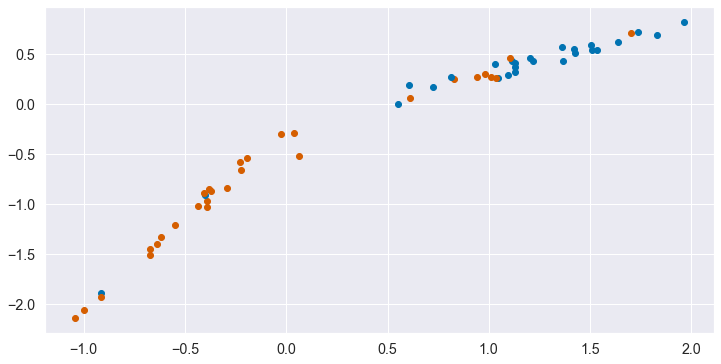

In [105]:
plot_encoding(encoding_test, labels, show_only=(0, 3));

In [110]:
def plot_encoding_with_colors(encoding, labels, color_vals, figsize=(12, 6), show_only=None):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    palette = sns.color_palette()
    
    x_d, y_d = [], []
    colors = []
    
    for i, code in enumerate(encoding):
        if show_only is not None and labels[i] not in show_only:
            continue
        
        x_d.append(encoding[i,0])
        y_d.append(encoding[i,1])
        colors.append(color_vals[i])
    
    sc = ax.scatter(x_d, y_d, c=colors, cmap='YlOrRd')
    plt.colorbar(sc)
    
    return f, ax

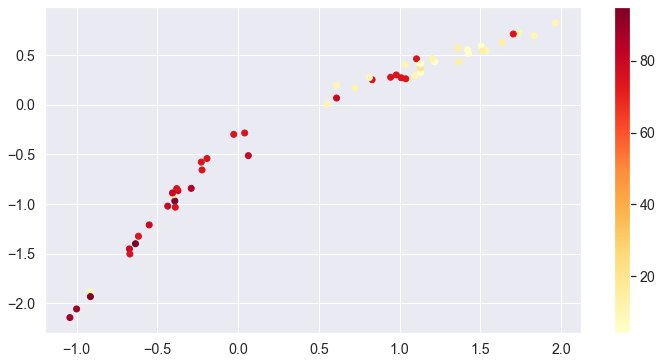

In [118]:
plot_encoding_with_colors(encoding_test, labels, temp_test, show_only=(0, 3));